In [63]:
import torch
import os
import sys
PROJECT_ROOT = os.path.abspath("../..")
sys.path.insert(0, PROJECT_ROOT)

print("Project root:", PROJECT_ROOT)

import matplotlib.pyplot as plt
import numpy as np
from memorization.data_prep.subset_imagenet import get_balanced_imagenet_dataset

Project root: /BS/scene_repre/work/VAR


In [79]:
unit_mem_file = PROJECT_ROOT + "/memorization/unitmem_scores_single_prev.pt"

In [65]:
def read_unit_mem_and_meta_data(unit_mem_file):
    """
    Given the file that stores unit mem scores, extract the unit_mem scores "shape: (num_units,)"
    and the details about that unit: "component type: fc1/fc2/attention, etc", "block", "scale", "unit itself"
    """

    unit_mem_dict = torch.load(unit_mem_file)
    all_scores = []
    
    all_meta = []  # (key, block, scale, unit)

    for key, blocks in unit_mem_dict.items():
        for block_idx, block in enumerate(blocks):
            # block: list of scales
            for scale_idx, unitmem_vec in enumerate(block):
                # unitmem_vec: (C,)
                C = unitmem_vec.numel()
                all_scores.append(unitmem_vec)  # tensor, NOT item()
                all_meta.extend(
                    (key, block_idx, scale_idx, unit)
                    for unit in range(C)
                )

    # Concatenate once
    scores = torch.cat(all_scores)  # shape: (num_units,)

    return scores, all_meta


In [66]:
def find_topk_memorizing_units_indices(unit_mem_scores, top_k_percent=0.9):
    """
    Given the unit_mem_scores tensor of shape (num_units,), find the units that have scores above the threshold.
    """

    threshold = torch.quantile(unit_mem_scores, top_k_percent)
    print(f"UnitMem {int(top_k_percent * 100)}% threshold: {threshold.item():.4f}")

    mask = unit_mem_scores >= threshold
    top_indices = torch.where(mask)[0]

    print(f"Number of top ~10% neurons: {top_indices.numel()}")

    return top_indices


In [67]:
def plot_distribution_of_topk_memorizing_units(top_indices, meta):
    # Build a heatmap of top-memorizing units across (block, scale)

    # Determine grid shape 
    num_blocks = 16
    num_scales = 10

    counts = np.zeros((num_blocks, num_scales), dtype=int)

    # Aggregate counts for top-memorizing units
    for i in top_indices.tolist():
        # all_meta[i] = (key, block_idx, scale_idx, unit)
        _, block_idx, scale_idx, _ = all_meta[i]
        counts[block_idx, scale_idx] += 1

    # Plot heatmap
    plt.figure(figsize=(6, 5))
    im = plt.imshow(counts, cmap="Blues", aspect="auto", origin="lower")
    cb = plt.colorbar(im, fraction=0.046, pad=0.04)
    cb.set_label("# top-memorizing units")
    plt.xlabel("Scale")
    plt.ylabel("Block")
    plt.xticks(ticks=np.arange(num_scales))
    plt.yticks(ticks=np.arange(num_blocks))
    #plt.title("Distribution of top-10% memorizing units across (block, scale)")

    # find total number of top-memorizing units
    total_top_units = counts.sum()
    # Optional: annotate non-zero cells
    max_c = counts.max() if counts.size > 0 else 0
    if max_c > 0:
        for b in range(num_blocks):
            for s in range(num_scales):
                c = counts[b, s]
                if c > 0:
                    color = "white" if c > max_c / 2 else "black"
                    plt.text(s, b, f"{c/total_top_units:.3f}", ha="center", va="center", color=color, fontsize=8)

    plt.tight_layout()
    plt.show()

UnitMem 90% threshold: 0.6442
Number of top ~10% neurons: 65536


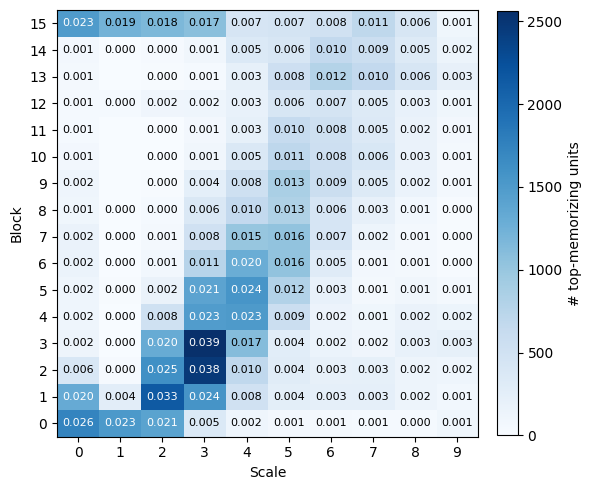

In [80]:
scores, all_meta = read_unit_mem_and_meta_data(unit_mem_file)
top_indices = find_topk_memorizing_units_indices(scores, top_k_percent=0.9)
plot_distribution_of_topk_memorizing_units(top_indices, all_meta)

In [69]:
"""
Now, coming to analyzing the images that are highly memorized.
"""

'\nNow, coming to analyzing the images that are highly memorized.\n'

In [70]:
def extract_activations_of_unit(activations_file):
    """
    Given the path to the folder that contains block_0.pt, block_1.pt, ..., block_15.pt,
    load and return the list of activations for each block.
    """
    
    blocks = []

    for i in range(16):
        blocks.append(torch.load(os.path.join(activations_file, f"block_{i}.pt")))  # shape: (N, C, H, W)

    return blocks

In [71]:
def find_topk_memorized_image_indices(blocks, top_x_memorized_units):
    # prepare some indices to check the images
    # top_20_memorized_units: block and scale
    # find the image that causes the max activation for each of these units
    memorized_image_indices = []
    for block_idx, scale_idx, unit_idx in top_x_memorized_units:
        block = blocks[block_idx]
        unit_activations = block['activations'][:, scale_idx, unit_idx]  # shape: (num_images,)
        
        max_activation, max_idx = torch.max(unit_activations, dim=0)
        memorized_image_indices.append(max_idx.item())
    return memorized_image_indices

In [72]:
def plot_memorized_images(dataset, memorized_image_indices):
    # show images in grid 5 by 4
    num_images = len(memorized_image_indices)
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    plt.figure(figsize=(8, 7))
    for i, img_idx in enumerate(memorized_image_indices):
        img, label = dataset[img_idx]
        plt.subplot(num_rows, num_cols, i + 1)
        img = (img + 1) / 2
        img = img.clamp(0, 1)

        plt.imshow(img.permute(1, 2, 0).numpy())
        plt.axis("off")

In [73]:
# load the dataset
dataset = get_balanced_imagenet_dataset(split="train", total_samples=12800)

In [74]:
top_mem_neurons = [
    (scores[i].item(), *all_meta[i])
    for i in top_indices.tolist()
]

# sort based on unit mem score
top_mem_neurons.sort(reverse=True)

In [75]:
# save the block and scale of the top 50 highly memorizing units
top_k_memorized_units = []
for x in top_mem_neurons[:20]:
    top_k_memorized_units.append((x[2], x[3], x[4]))

In [77]:
path = "/scratch/inf0/user/hpetekka/var_mem/output_activation_all_prev_scales/combined/fc1_act"
blocks = extract_activations_of_unit(path)

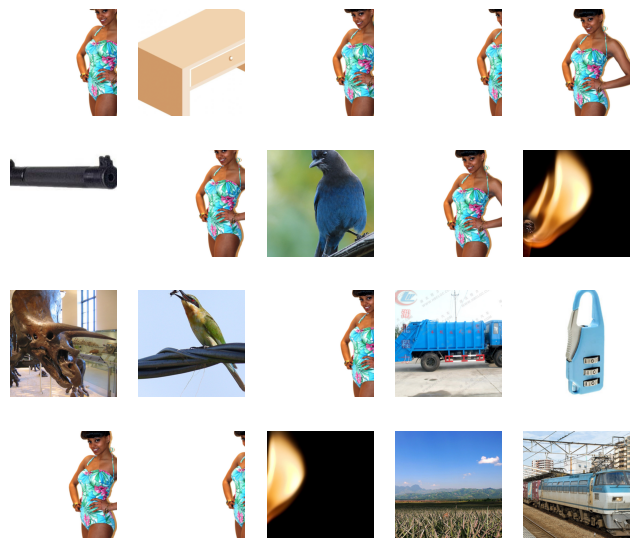

In [78]:
memorized_image_indices = find_topk_memorized_image_indices(blocks, top_k_memorized_units)
plot_memorized_images(dataset, memorized_image_indices)